<a href="https://colab.research.google.com/github/pleunipennings/CSC508_ML_Biomedicine_Class/blob/main/Module5/Module_5a_Adni_BoostedTrees_PatData_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Gradient-Boosted Trees notebook!
This notebook was created at San Francisco State University for the PINC and gSTAR programs by Dr Pleuni Pennings, Lucy Moctezuma Tan and Lorena Benitez Rivera. We acknowledge help from Dr Adegoke Ojewole and Dr Hector Corrada Bravo from Genentech.

# Opening the file location and loading libraries

In [118]:
# Below we are importing necessary libraries
import pandas as pd
import numpy as np

# Importing packages for Creating ML model and Evaluating it
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Importing library for plots
from matplotlib import pyplot as plt
from xgboost import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

Read the dataset "PatData_cleaned.csv", this dataset is already cleaned, we have dropped all missing values and it should only contain the main diagnoses:

|Diagnosis|Meaning|
|---|---|
|NL|Cognitively normal|
|MCI|Mild Cognitive Impairment|
|Dementia|Person that has Alzheimer's Disease|

In [119]:
# Reading cleaned Dataset from Github
url = "https://raw.githubusercontent.com/pleunipennings/CSC508Data/main/PatData_cleaned.csv"
data = pd.read_csv(url)
data.head()

,PTID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,DX,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
0,002_S_0295,84.8,2,18,1,1,1,1.0,NL,43332.500000,6805.125000,1.071568e+06,3752.625000,17693.875000,19420.125000,1.649602e+06
1,002_S_0413,76.3,1,16,1,1,1,0.0,NL,31936.454545,6824.636364,1.055413e+06,4131.090909,20095.909091,20235.545455,1.600009e+06
2,002_S_0559,79.3,2,16,1,1,2,1.0,NL,38410.666667,7496.666667,1.092807e+06,3998.333333,18993.000000,22226.000000,1.703968e+06
3,002_S_0619,77.5,2,12,1,1,1,2.0,Dementia,120529.500000,5812.000000,1.093932e+06,2773.000000,20675.000000,19959.000000,2.070530e+06
4,002_S_0685,89.6,1,16,1,1,1,0.0,NL,40921.571429,7063.250000,9.800458e+05,3894.375000,14152.250000,18133.625000,1.521331e+06


In [120]:
# checking counts for people with each type of diagnosis
data['DX'].value_counts()

MCI         559
Dementia    522
NL          398
Name: DX, dtype: int64

##  Preparing Training Data and Creating Gradient Boosted Tree Model Object

Split the data in labels (the diagnosis) and features (the other columns).  
Every algorithm works a bit differently depending on how each package is written, which is why it is always important to be updated on changes of your more used packages. In this particular case we see that for the Gradient Boosted tree from sklearn package the labels need to be numeric.

In [121]:
# Separating labels from the general dataframe
labels = data["DX"]

# Creating a label encoder object
le = preprocessing.LabelEncoder()

# Fitting the label encoder into the labels columns
le.fit(data["DX"])

# Transforming the classes into numbers
labels_t = le.transform(data["DX"])

Below we can see our actual named Diagnosis, and then our transformed labels. As you can see now:
- Dementia = 0
- MCI = 1
- NL = 2

In [122]:
# Printing the classes we have
list(le.classes_)

['Dementia', 'MCI', 'NL']

In [123]:
# Printing how labels got transformed
np.unique(labels_t)

array([0, 1, 2])

Now for our features we will drop patient ID, because it does not help us make any predictions and we drop the diagnosis since that is our label. All other columns should be considered as predictor features.

In [124]:
# Dropping unnecessary columns for our features
features = data.drop(columns=['PTID','DX'])

The next part we should be pretty familiar with at this point:
 - We will separate our training and testing datasets using the labels and features we have been stablished.
 - We create the ML model object in this case it is Our Gradient Boosted Trees

**NOTE:** Notice that I have set ahead of time a couple of hyperparameters for my Gradient Boosted Tree already, such as a **seed** (for reproducible results), **eval_metric** (metric used to measure error, in this case is: "merror"), **max_depth** (each tree created will have a max of 4 layers deep before getting to a leaf), **learning_rate** (How fast we want our model to learn), **n_estimators** (Number of trees created by our model per class)

In [125]:
# As mentioned in the textbook, we use about 70-80% of our data as the training data and the rest as test data. In the code, 70% training and 30% test
features_train, features_test, labels_train, labels_test = train_test_split(features, labels_t, test_size=0.3, random_state=42)

#Create a Gradient Boosted Tree
gbt = XGBClassifier(seed = 42, eval_metric="merror", max_depth=4, learning_rate=0.5, n_estimators=50)

## Training using validation Data Gradient Boosted Tree

In order to illustrate how each tree created in the Gradient Boosted Tree improves, I will use a small validation dataset from the training data everytime our model makes a new tree.

- **Validation Data:** Must come from training data because, our test set is reserved for our final evaluation of the model. We use it in our example below so that you can see behind the scenes how much each iteration of trees get better results. In our case we will use 20 percent of our training data for our validation test.

**NOTE:** We should never use the test data during training because that would bias our model. This would be like knowing ahead of time the exact questions for an exam and then scoring high!

In [126]:
# Extracting validation data from training data
X_train, X_valid, Y_train, Y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

# Validation set
validation_set = [(X_train,Y_train),(X_valid, Y_valid)]

# Train a gradient Boosted Tree with validation data
gbt.fit(features_train, labels_train , eval_set = validation_set)

[0]	validation_0-merror:0.33696	validation_1-merror:0.27536
[1]	validation_0-merror:0.29710	validation_1-merror:0.25121
[2]	validation_0-merror:0.26691	validation_1-merror:0.23671
[3]	validation_0-merror:0.26570	validation_1-merror:0.25604
[4]	validation_0-merror:0.24275	validation_1-merror:0.22222
[5]	validation_0-merror:0.22585	validation_1-merror:0.21256
[6]	validation_0-merror:0.21256	validation_1-merror:0.20773
[7]	validation_0-merror:0.18478	validation_1-merror:0.17874
[8]	validation_0-merror:0.17271	validation_1-merror:0.16908
[9]	validation_0-merror:0.16908	validation_1-merror:0.16908
[10]	validation_0-merror:0.16063	validation_1-merror:0.15459
[11]	validation_0-merror:0.15459	validation_1-merror:0.13043
[12]	validation_0-merror:0.13647	validation_1-merror:0.12560
[13]	validation_0-merror:0.13043	validation_1-merror:0.13527
[14]	validation_0-merror:0.12077	validation_1-merror:0.11594
[15]	validation_0-merror:0.11232	validation_1-merror:0.11111
[16]	validation_0-merror:0.10145	v

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

The output above shows us 2 columns, the first shows us how our model is doing in 80% percent of our training data, whereas the the other column shows what our validation set (20% of training data) is doing at each iteration. Looking at both columns at the same time we can get an idea of whether we might be overfirring or not. Since we are using the **merror** (Multiclass classification Error Rate) as our metric, we want to see that both columns show a decrease in this metric. As you can see they both do.

**NOTE:** For Multiclass Classifications the Gradient Boosted Tree Model actually creates 50 trees for each class! Dementia, MCI and NL.

Below you can actually get a summary of all the trees that were created. There are a lot of trees so we wont print all of them considering there is (50 X 3 classes) 150 trees total!

In [127]:
# creating a list of all the trees created
gbt_treelist = gbt.get_booster().get_dump()
# Getting total amount of trees from XGboost Classifier model
print(len(gbt_treelist))

150


Here we can for example look at the first 2 trees created. The results below shows you the index for each node it creates for both of the trees. For example the **root node [index = 0] for the first tree is [Entorhinal<3239.82129]**

In [128]:
# Check the total amopunt of trees
for tree in gbt_treelist[0:2]:
  print(tree)

0:[Entorhinal<3265.80005] yes=1,no=2,missing=2
	1:[Hippocampus<6891.7998] yes=3,no=4,missing=4
		3:[Fusiform<14917] yes=7,no=8,missing=8
			7:[Entorhinal<2989.33325] yes=15,no=16,missing=16
				15:leaf=0.629948378
				16:leaf=0.168539315
			8:[APOE4<1] yes=17,no=18,missing=18
				17:leaf=0.0280373618
				18:leaf=0.401408434
		4:[ICV<1444914] yes=9,no=10,missing=10
			9:[APOE4<2] yes=19,no=20,missing=20
				19:leaf=-0.341584176
				20:leaf=-1.2772424e-08
			10:[MidTemp<20947.334] yes=21,no=22,missing=22
				21:leaf=0.130434766
				22:leaf=-0.182926849
	2:[Ventricles<58069.75] yes=5,no=6,missing=6
		5:[Hippocampus<5920] yes=11,no=12,missing=12
			11:[PTRACCAT<2] yes=23,no=24,missing=24
				23:leaf=0.194805175
				24:leaf=-0.24000001
			12:[APOE4<2] yes=25,no=26,missing=26
				25:leaf=-0.301121235
				26:leaf=-0.049586799
		6:[ICV<1736485] yes=13,no=14,missing=14
			13:[Hippocampus<5973] yes=27,no=28,missing=28
				27:leaf=0.32432431
				28:leaf=-0.156108618
			14:[Entorhinal<4123.5] yes=

## Visualizing one tree from our Gradient Boosted Trees Model

The text summary above looks so convoluted and ugly! Below we can visualize one of our trees from our Gradient Boosted Tree Model. Lets choose in this case to look at the very first tree. You can change the index of the tree by changing the argument **num_trees**. Notice that this tree is just laying on its side, the rootnode is on the left while the leaves are towards the right.

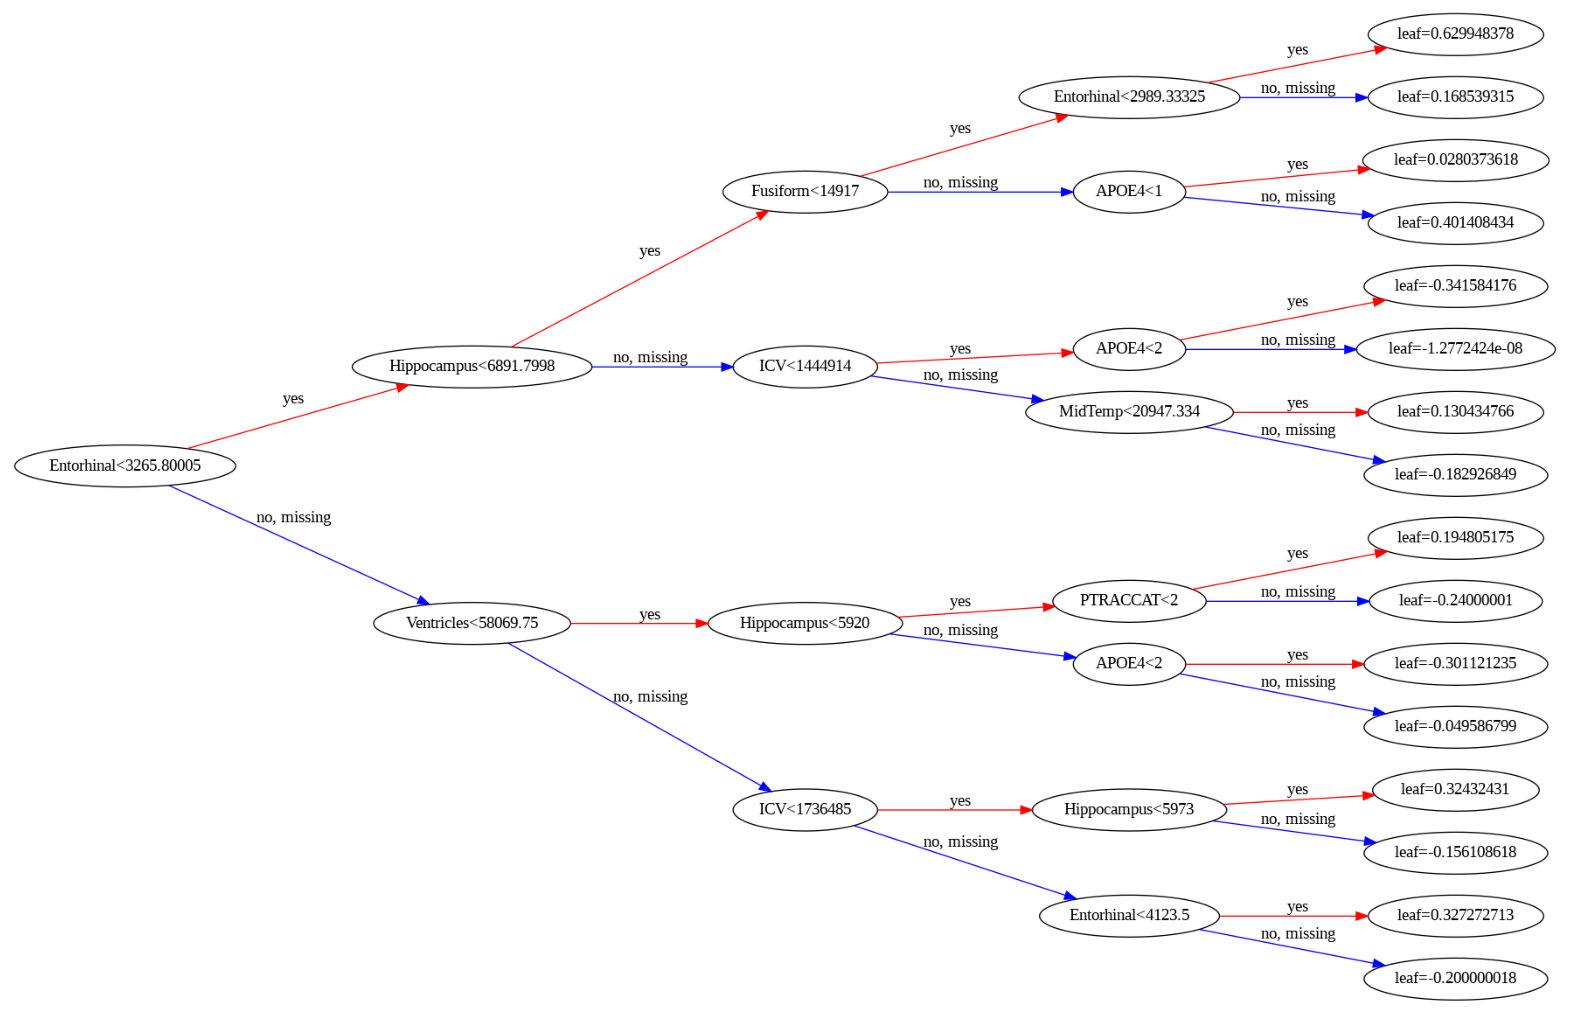

In [129]:
# Making a graph for our very first tree in Gradient Boosted Tree model
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(gbt, num_trees=0, ax=ax, rankdir="LR")
plt.show()


### Task 1: looking at the trees.

1. Try plotting 2 or 3 more Decisions trees created. Why do you think they have 4 or less layers?

In [130]:
# graph some trees here and answer your question

**Answer to task 1**
I think there are only 4 or less layers due to the diagnoses we have and the max height hyper parameter.

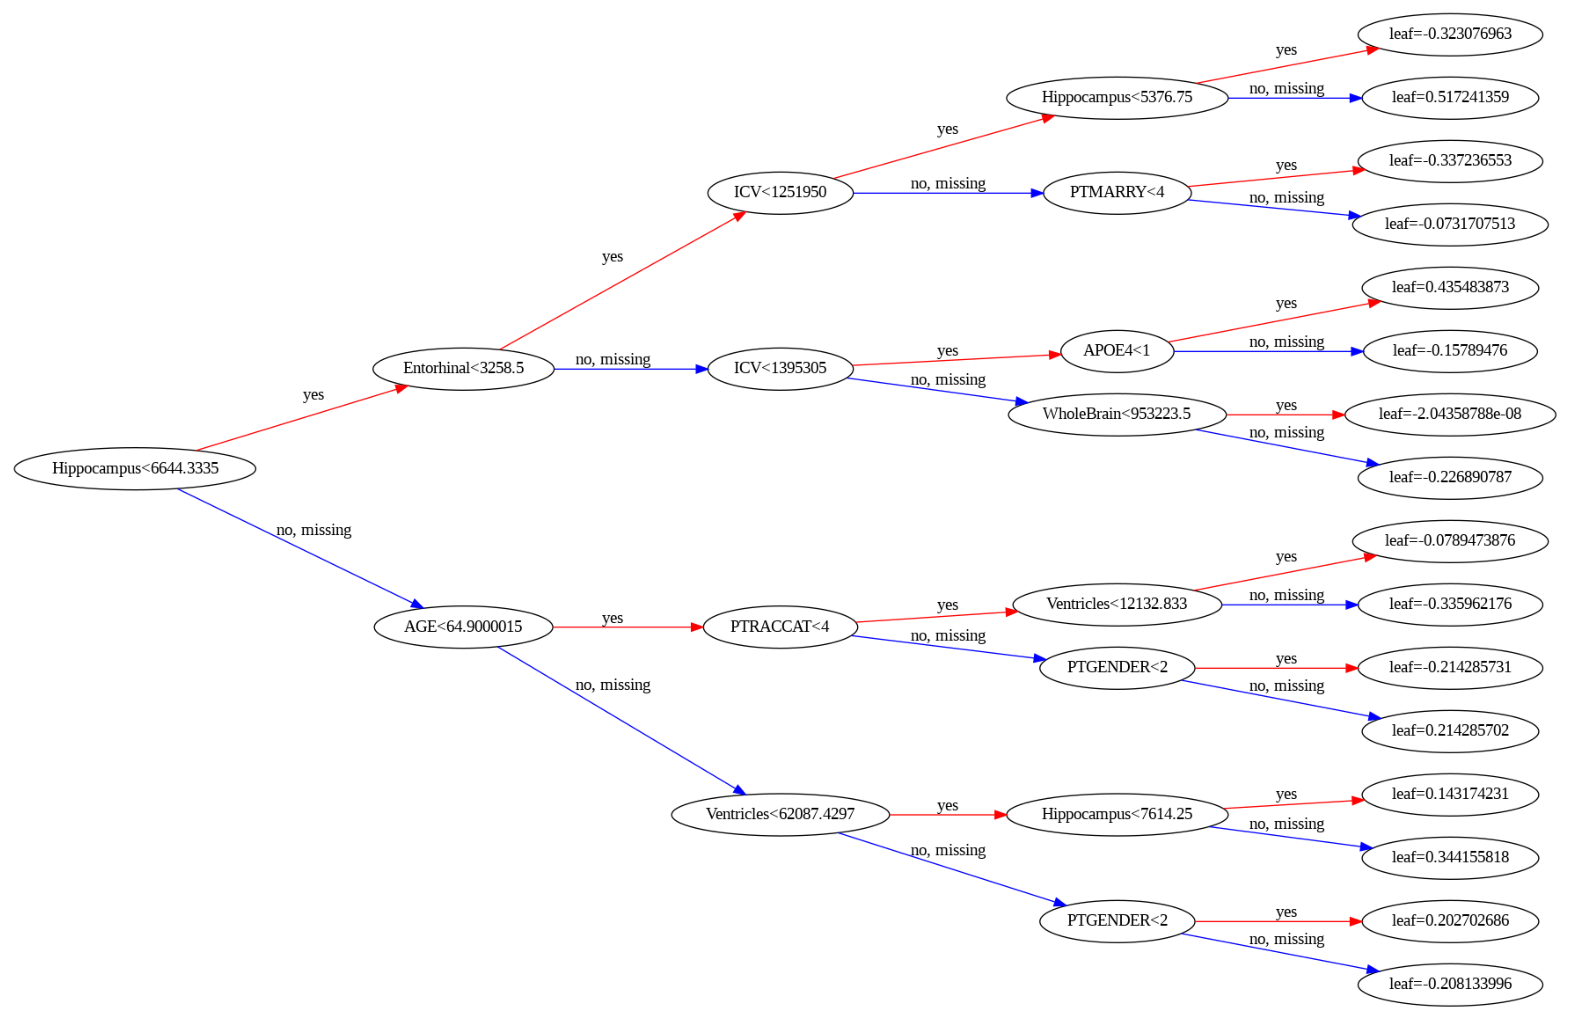

In [131]:
# Making a graph for our very first tree in Gradient Boosted Tree model
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(gbt, num_trees=2, ax=ax, rankdir="LR")
plt.show()

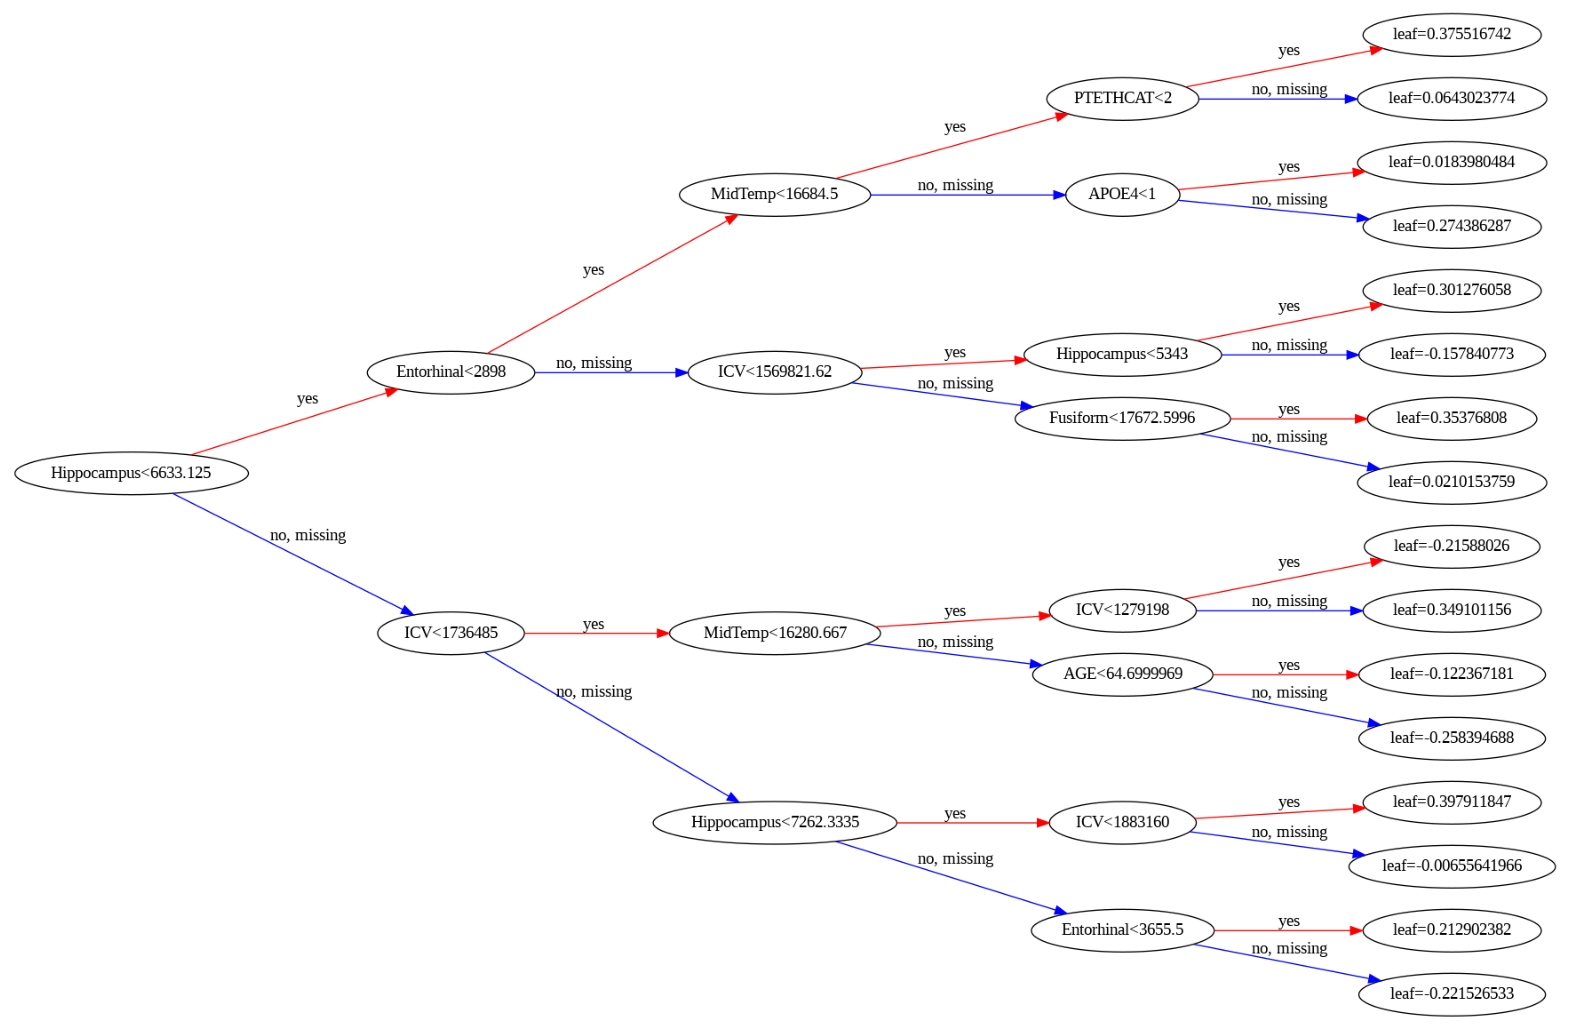

In [132]:
# Making a graph for our very first tree in Gradient Boosted Tree model
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(gbt, num_trees=3, ax=ax, rankdir="LR")
plt.show()

Recall however that one of the biggest difference between Random Forests and Gradient Boosted Trees is that not all trees have equal amount of say on the final decision. As each tree created in Gradient Boosted Tree model tries to take into account the errors from the previous one, the trees with the lowest errors should have more say than the ones with more errors.

## Evaluating our Gradient Boosted Tree

Below we will finally use our **TESTING DATA** to evaluate our model. Our Testing data has never been seen before by our model, so this evaluation would emulate how our model could perform once it is deployed. Below we will use our model to make predictions four out test data and the look at the first 10 predicted values

In [133]:
#Predict the response for test dataset
labels_pred = gbt.predict(features_test)

# Look at the predicted values.
print(labels_pred[:10])
#Compare with the real data from the test data set.
print(labels_test[:10])

[0 1 2 0 2 0 2 1 2 1]
[0 1 2 0 1 0 2 1 1 1]


The way a Gradient Boosted tree predicts each of the classes is through calculating different probabilities for each class. In the output below you can see that each row constitutes one prediction. Within each prediction we see 3 numbers. If you sum all the three number you get 100%. The index with the highest number is the final label predicted. Below is an example for the first predicted label:

|DX:|Dementia|Mild Cognitive Impairment|Normal|
|---|---|---|---|
|Index|0|1|2|
|Probabilities|0.9004508|0.05835567|0.0411935|

In [134]:
# getting the probabilities predicted for each class
preds_proba = gbt.predict_proba(features_test)
print(preds_proba)

[[0.946817   0.02875213 0.02443093]
 [0.12491538 0.46436474 0.41071984]
 [0.13575764 0.06168981 0.8025525 ]
 ...
 [0.00983566 0.59263474 0.3975296 ]
 [0.53526217 0.43542042 0.02931739]
 [0.4863515  0.3839223  0.12972619]]


### Task 2:
What are the 10 first diagnosis predicted by our Gradient Boosted Tree?

**Answer for Task 2**

0 = dementia, 1 = mci, 2 = normal

0 1 2 0 2 0 2 1 2 1

Below we will be plotting a Confusion matrix to Check to Check how our Gradient Boosted Tree has performed. We will also be calculating it's accuracy.

[[129  38   6]
 [ 25  92  41]
 [  5  46  62]]


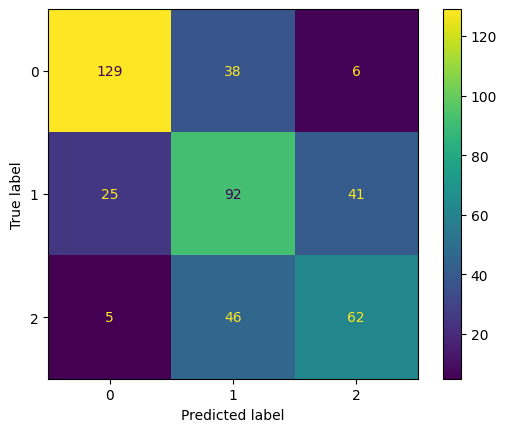

In [135]:
#Let's visualize how well the GBT does.
print(metrics.confusion_matrix(labels_test, labels_pred))
plt2 = metrics.ConfusionMatrixDisplay.from_estimator(gbt, features_test, labels_test)
plt.grid(False)

In [136]:
# We want to check the accuracy in predicting the test data to make sure the model is not overfitted to the training data
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.1f%%" % (accuracy * 100))

Accuracy: 63.7%


#Task 3: Boosted trees

Now it's your turn to train a Gradient-boosted tree model and a Random Forest model, and see which one does better in terms of overall accuracy.

To make sure your model is a bit different from what we did previously in this notebook, I want you to choose just two of the diagnosis categories (NL, MCI, Dementia). With just two categories, the accuracy may become better than what we had before.  

1. Create your smaller dataset with just two diagnosis categories.
2. Split label and features, split training and test.
3. Fit your models (gradient boosted trees and random forest).
4. Predict for your test data and calculate accuracies.
5. Plot your results in a confusion matrix.
6. Which of the model does better? Is it a big difference? Do you think that any hyperparameter tuning could improve them?



In [137]:
# Create a Random Forest Model, train and evaluate it

In [138]:
# Reading cleaned Dataset from Github
url = "https://raw.githubusercontent.com/pleunipennings/CSC508Data/main/PatData_cleaned.csv"
data = pd.read_csv(url)
data.head()

,PTID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,DX,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
0,002_S_0295,84.8,2,18,1,1,1,1.0,NL,43332.500000,6805.125000,1.071568e+06,3752.625000,17693.875000,19420.125000,1.649602e+06
1,002_S_0413,76.3,1,16,1,1,1,0.0,NL,31936.454545,6824.636364,1.055413e+06,4131.090909,20095.909091,20235.545455,1.600009e+06
2,002_S_0559,79.3,2,16,1,1,2,1.0,NL,38410.666667,7496.666667,1.092807e+06,3998.333333,18993.000000,22226.000000,1.703968e+06
3,002_S_0619,77.5,2,12,1,1,1,2.0,Dementia,120529.500000,5812.000000,1.093932e+06,2773.000000,20675.000000,19959.000000,2.070530e+06
4,002_S_0685,89.6,1,16,1,1,1,0.0,NL,40921.571429,7063.250000,9.800458e+05,3894.375000,14152.250000,18133.625000,1.521331e+06


In [139]:
# checking counts for people with each type of diagnosis
data['DX'].value_counts()


MCI         559
Dementia    522
NL          398
Name: DX, dtype: int64

In [140]:
##mask = data['DX'] == 'NL'

#data = data[~mask]

In [141]:
data = data.drop(data[data['DX'] == 'NL'].index)

In [142]:
# checking counts for people with each type of diagnosis
data['DX'].value_counts()

MCI         559
Dementia    522
Name: DX, dtype: int64

In [143]:
# Separating labels from the general dataframe
labels = data["DX"]

# Creating a label encoder object
le = preprocessing.LabelEncoder()

# Fitting the label encoder into the labels columns
le.fit(data["DX"])

# Transforming the classes into numbers
labels_t = le.transform(data["DX"])

In [144]:
# Printing the classes we have
list(le.classes_)

['Dementia', 'MCI']

In [145]:
# Printing how labels got transformed
np.unique(labels_t)

array([0, 1])

In [146]:
# Dropping unnecessary columns for our features
features = data.drop(columns=['PTID','DX'])

In [147]:
# As mentioned in the textbook, we use about 70-80% of our data as the training data and the rest as test data. In the code, 70% training and 30% test
features_train, features_test, labels_train, labels_test = train_test_split(features, labels_t, test_size=0.2, random_state=42)

#Create a Gradient Boosted Tree
gbt1 = XGBClassifier(learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    nthread=4,
    scale_pos_weight=1,
    seed=27,
    num_class=2,)

In [148]:
# Create a Gradient Boosted Tree Model, train and evaluate it

In [149]:
np.unique(labels_t)

array([0, 1])

In [150]:
# Extracting validation data from training data
X_train, X_valid, Y_train, Y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

# Validation set
validation_set = [(X_train,Y_train),(X_valid, Y_valid)]

# Train a gradient Boosted Tree with validation data
gbt1.fit(features_train, labels_train , eval_set = validation_set)

[0]	validation_0-mlogloss:0.64898	validation_1-mlogloss:0.64855
[1]	validation_0-mlogloss:0.61102	validation_1-mlogloss:0.61294
[2]	validation_0-mlogloss:0.58113	validation_1-mlogloss:0.58301
[3]	validation_0-mlogloss:0.55392	validation_1-mlogloss:0.55665
[4]	validation_0-mlogloss:0.52626	validation_1-mlogloss:0.53150
[5]	validation_0-mlogloss:0.50059	validation_1-mlogloss:0.50894
[6]	validation_0-mlogloss:0.47981	validation_1-mlogloss:0.48895
[7]	validation_0-mlogloss:0.46015	validation_1-mlogloss:0.47200
[8]	validation_0-mlogloss:0.44295	validation_1-mlogloss:0.45594
[9]	validation_0-mlogloss:0.42863	validation_1-mlogloss:0.44001
[10]	validation_0-mlogloss:0.41404	validation_1-mlogloss:0.42471
[11]	validation_0-mlogloss:0.40123	validation_1-mlogloss:0.41300
[12]	validation_0-mlogloss:0.38925	validation_1-mlogloss:0.40005
[13]	validation_0-mlogloss:0.37749	validation_1-mlogloss:0.38960
[14]	validation_0-mlogloss:0.36604	validation_1-mlogloss:0.37903
[15]	validation_0-mlogloss:0.35644	

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:44:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-mlogloss:0.28259	validation_1-mlogloss:0.30251
[27]	validation_0-mlogloss:0.27914	validation_1-mlogloss:0.29858
[28]	validation_0-mlogloss:0.27382	validation_1-mlogloss:0.29387
[29]	validation_0-mlogloss:0.26851	validation_1-mlogloss:0.29042
[30]	validation_0-mlogloss:0.26449	validation_1-mlogloss:0.28600
[31]	validation_0-mlogloss:0.26055	validation_1-mlogloss:0.28161
[32]	validation_0-mlogloss:0.25770	validation_1-mlogloss:0.27746
[33]	validation_0-mlogloss:0.25282	validation_1-mlogloss:0.27196
[34]	validation_0-mlogloss:0.24849	validation_1-mlogloss:0.26848
[35]	validation_0-mlogloss:0.24523	validation_1-mlogloss:0.26612
[36]	validation_0-mlogloss:0.24135	validation_1-mlogloss:0.26178
[37]	validation_0-mlogloss:0.23748	validation_1-mlogloss:0.25697
[38]	validation_0-mlogloss:0.23434	validation_1-mlogloss:0.25369
[39]	validation_0-mlogloss:0.23084	validation_1-mlogloss:0.25001
[40]	validation_0-mlogloss:0.22818	validation_1-mlogloss:0.24618
[41]	validation_0-mloglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=4,
              num_class=2, ...)

In [151]:
# creating a list of all the trees created
gbt1_treelist = gbt1.get_booster().get_dump()
# Getting total amount of trees from XGboost Classifier model
print(len(gbt_treelist))

150


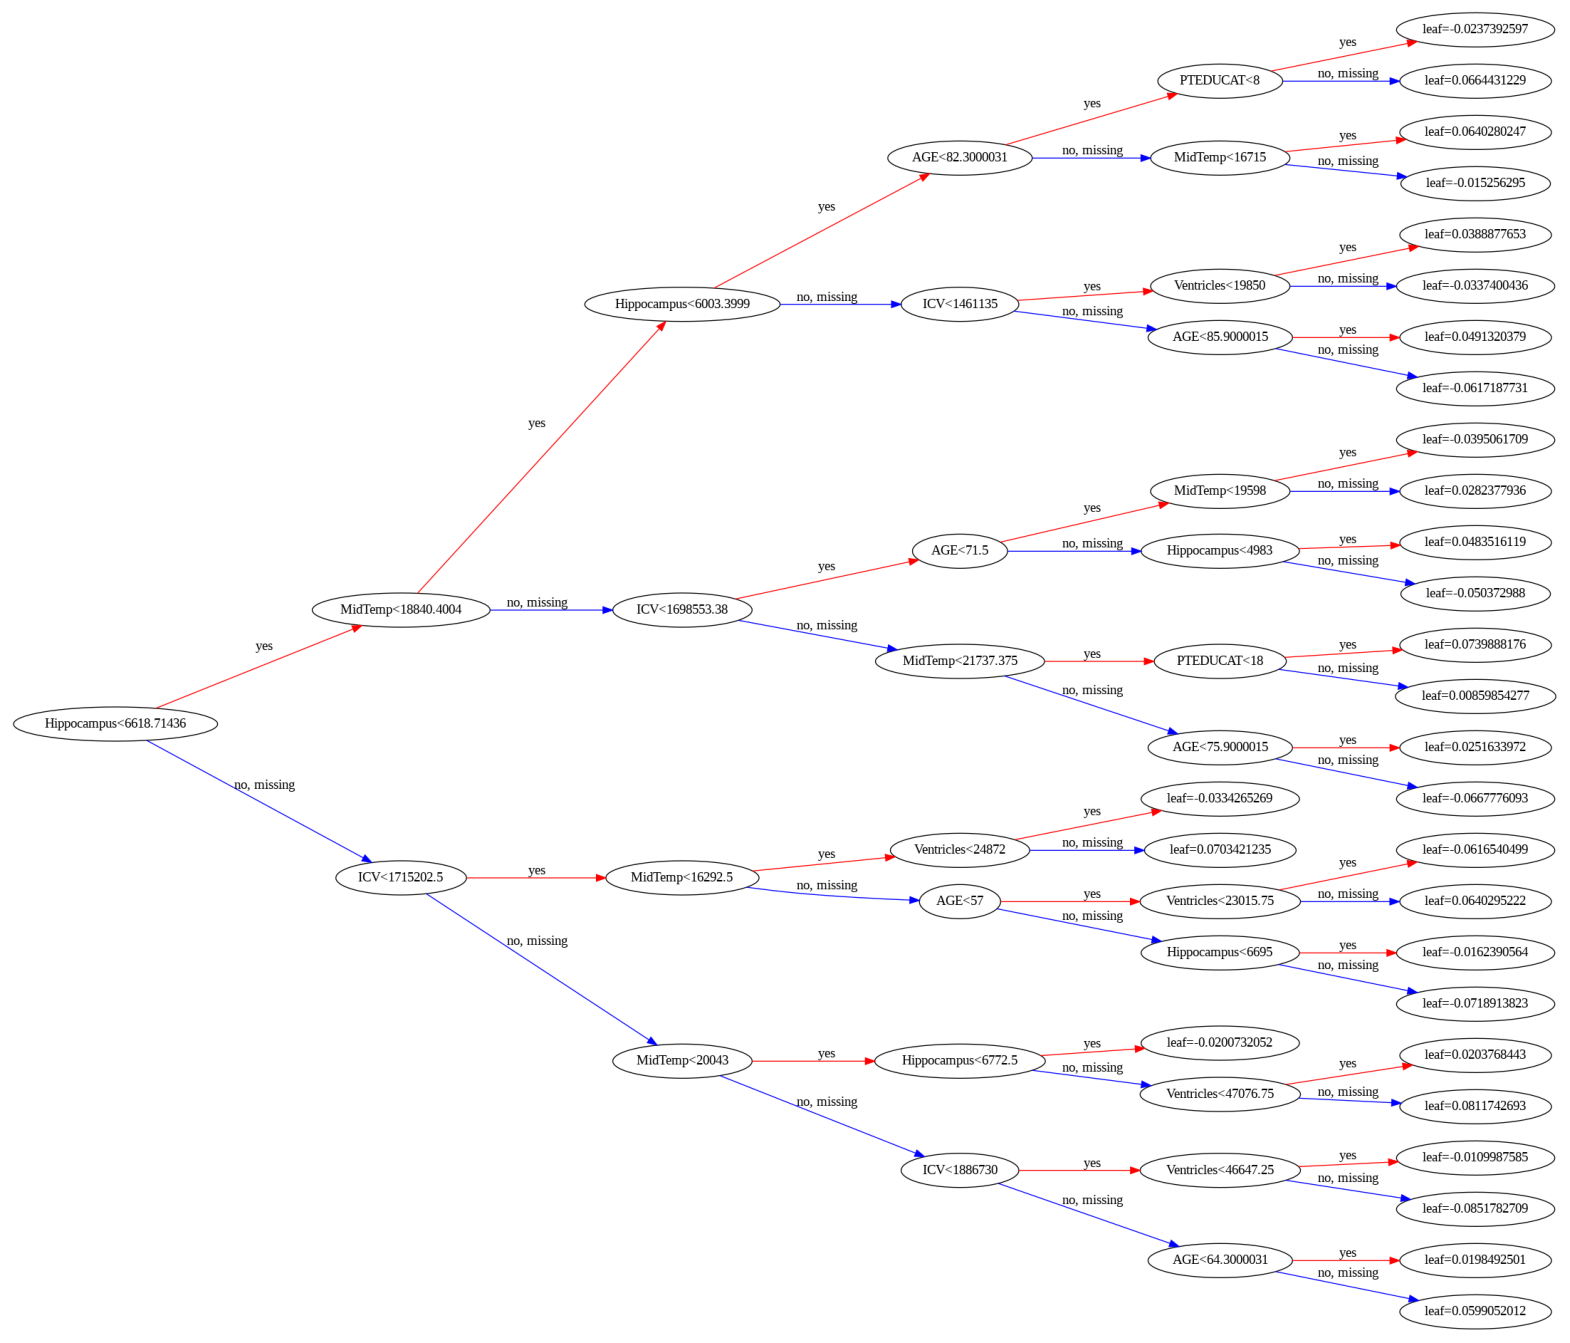

In [152]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(gbt1, num_trees=2, ax=ax, rankdir="LR")
plt.show()

In [153]:
#Predict the response for test dataset
labels_pred = gbt1.predict(features_test)

# Look at the predicted values.
print(labels_pred[:10])
#Compare with the real data from the test data set.
print(labels_test[:10])

[1 0 0 0 1 1 1 0 0 1]
[1 0 1 0 1 1 0 0 1 1]


In [154]:
# getting the probabilities predicted for each class
preds_proba = gbt1.predict_proba(features_test)
print(preds_proba)

[[7.48027712e-02 9.25197244e-01]
 [5.42350292e-01 4.57649738e-01]
 [9.69627678e-01 3.03723533e-02]
 [9.99862552e-01 1.37418567e-04]
 [1.52728856e-02 9.84727144e-01]
 [1.78977774e-04 9.99821007e-01]
 [9.00837884e-04 9.99099135e-01]
 [9.72329676e-01 2.76703537e-02]
 [5.99989057e-01 4.00010973e-01]
 [7.72444531e-03 9.92275536e-01]
 [6.94046379e-04 9.99305964e-01]
 [2.12952509e-04 9.99787033e-01]
 [1.07155960e-04 9.99892831e-01]
 [3.67412606e-04 9.99632597e-01]
 [3.30861621e-02 9.66913819e-01]
 [2.16226541e-02 9.78377283e-01]
 [9.91539061e-01 8.46096687e-03]
 [1.50508678e-03 9.98494864e-01]
 [1.78650080e-03 9.98213530e-01]
 [6.89340814e-04 9.99310613e-01]
 [7.67217219e-01 2.32782811e-01]
 [9.99475300e-01 5.24771924e-04]
 [5.41899145e-01 4.58100855e-01]
 [9.99635577e-01 3.64394771e-04]
 [9.99982953e-01 1.70321200e-05]
 [2.43480746e-02 9.75651860e-01]
 [5.67153133e-02 9.43284690e-01]
 [8.18895459e-01 1.81104526e-01]
 [1.78449944e-01 8.21550071e-01]
 [1.46952050e-03 9.98530507e-01]
 [9.669719

[[88 17]
 [22 90]]


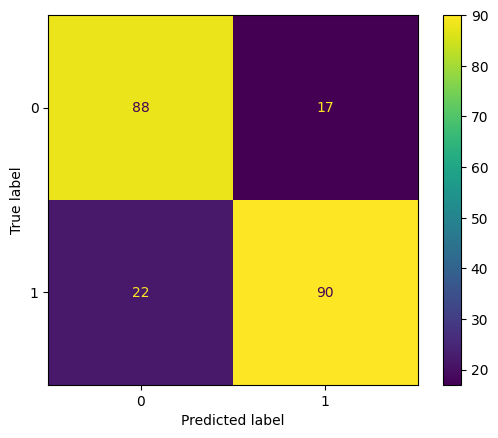

In [155]:
#Let's visualize how well the GBT does.
print(metrics.confusion_matrix(labels_test, labels_pred))
plt2 = metrics.ConfusionMatrixDisplay.from_estimator(gbt1, features_test, labels_test)
plt.grid(False)

**Answers for task 3**

I think my model does a better job of accurately predicting, I think it could be possibly improved by tuning the hyperparameters.